# Natural Language Processing Disaster Tweets with RNNs
## Problem Introduction

This project aims to classify a tweet as either Disaster related or not. The dataset I use comes from [Kaggle](https://www.kaggle.com/c/nlp-getting-started/overview).
The dataset contains 10,876 tweets that are classified as either a disaster tweet (1) or not (0). Each tweet can also contain keywords and locations that are pulled from the text, however these features are not required.






In [29]:
# Python Imports
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Set this before importing TensorFlow

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from collections import Counter
from gensim.models import KeyedVectors
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.mixed_precision import set_global_policy
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping
set_global_policy('mixed_float16')

## EDA



I go through a couple of visualizations exploring the dataset seen below. I've hidden the code so this section looks a little cleaner, but the code can still be examined by clicking the (...) if any analysis is needed.

- Preview of the training dataset
- Lengths of Test and Train Dataset
- Distribution across the two categories
- Word Count Distribution over the two categories
- Distribution of tweets with keywords across two classes
- Most common words across each of the two classes

In [2]:
# Load Test and Train Data + Data Preview
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
#Examining Size of Test and Train Sets
print(f'Length of Train Set: {len(train_df)}')
print(f'Length of Test Set:  {len(test_df)}')



Length of Train Set: 7613
Length of Test Set:  3263


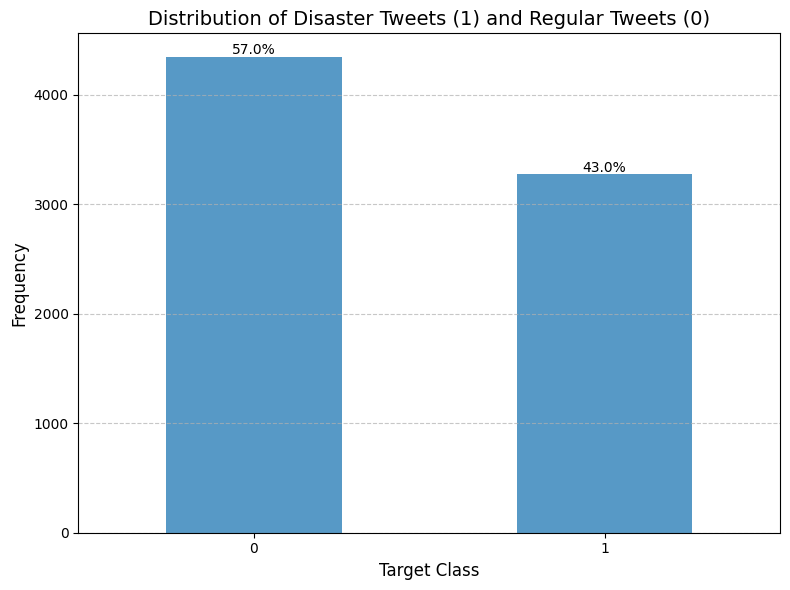

In [4]:
# Class Destributions Histogram
value_counts = train_df['target'].value_counts().sort_index()
percentages = (value_counts / value_counts.sum()) * 100

# Plotting the histogram
plt.figure(figsize=(8, 6))
ax = value_counts.plot(kind='bar', alpha=0.75)

# Adding labels and title
plt.title('Distribution of Disaster Tweets (1) and Regular Tweets (0)', fontsize=14)
plt.xlabel('Target Class', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add percentages above the bars
for i, (count, pct) in enumerate(zip(value_counts, percentages)):
    plt.text(i, count*1.006, f'{pct:.1f}%', ha='center', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()

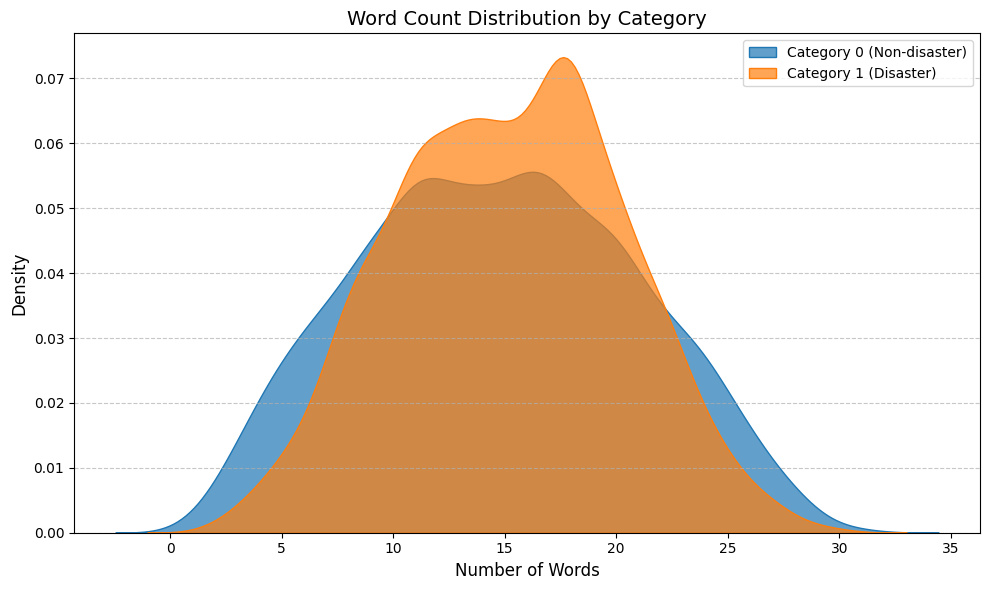

In [5]:
# Plot distribution of word count across the two categories

# Word Count
train_df['word_count'] = train_df['text'].apply(lambda x: len(x.split()))
test_df['word_count'] = test_df['text'].apply(lambda x: len(x.split()))

# Separate the data into two categories
category_0 = train_df[train_df['target'] == 0]['word_count']
category_1 = train_df[train_df['target'] == 1]['word_count']

# Plotting the distributions
plt.figure(figsize=(10, 6))

# Distribution for category 0
sns.kdeplot(category_0, fill=True, label='Category 0 (Non-disaster)', alpha=0.7)

# Distribution for category 1
sns.kdeplot(category_1, fill=True, label='Category 1 (Disaster)', alpha=0.7)

# Adding labels, legend, and title
plt.title('Word Count Distribution by Category', fontsize=14)
plt.xlabel('Number of Words', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

7552


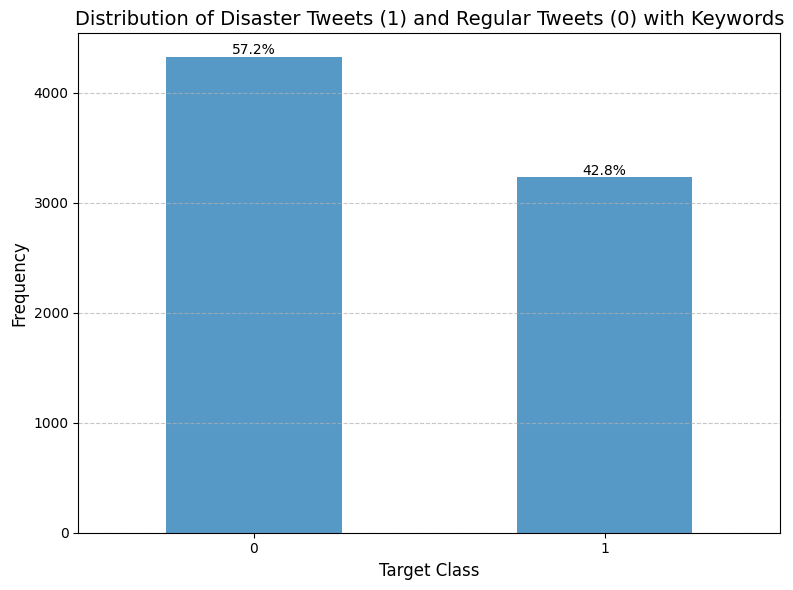

In [6]:
# Keyword distribution (Doesn't add much information)
keyword_df = train_df.loc[train_df['keyword'].notna()]
print(len(keyword_df))
# Class Destributions Histogram
value_counts = keyword_df['target'].value_counts().sort_index()
percentages = (value_counts / value_counts.sum()) * 100

# Plotting the histogram
plt.figure(figsize=(8, 6))
ax = value_counts.plot(kind='bar', alpha=0.75)

# Adding labels and title
plt.title('Distribution of Disaster Tweets (1) and Regular Tweets (0) with Keywords', fontsize=14)
plt.xlabel('Target Class', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add percentages above the bars
for i, (count, pct) in enumerate(zip(value_counts, percentages)):
    plt.text(i, count*1.006, f'{pct:.1f}%', ha='center', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()

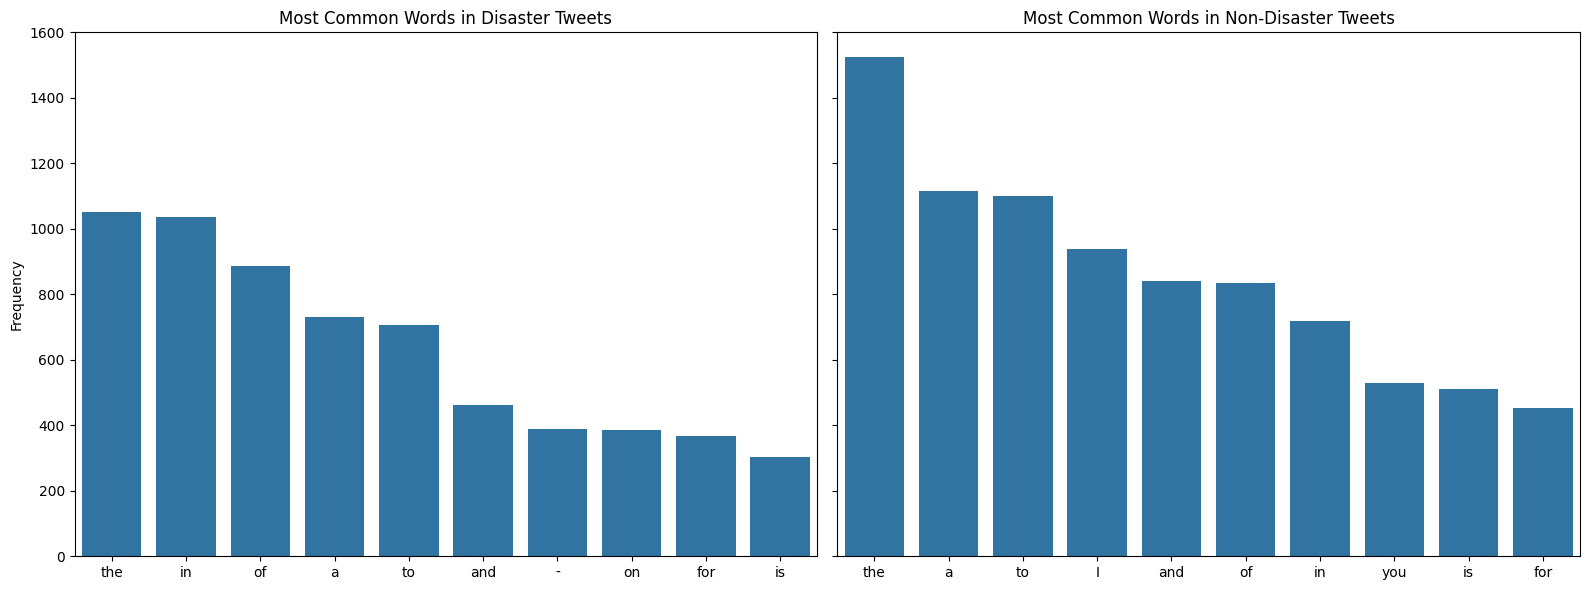

In [7]:
# Most common words across the two Classes
words_non_disaster = ' '.join(train_df[train_df['target'] == 0]['text']).split()
words_disaster = ' '.join(train_df[train_df['target'] == 1]['text']).split()

# Plot most common words
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot most common words in disaster tweets
sns.barplot(
    x=[x[0] for x in Counter(words_disaster).most_common(10)],
    y=[x[1] for x in Counter(words_disaster).most_common(10)],
    ax=axes[0]
)
axes[0].set_title('Most Common Words in Disaster Tweets')
axes[0].set_xlabel('')
axes[0].set_ylabel('Frequency')

# Plot most common words in non-disaster tweets
sns.barplot(
    x=[x[0] for x in Counter(words_non_disaster).most_common(10)],
    y=[x[1] for x in Counter(words_non_disaster).most_common(10)],
    ax=axes[1]
)
axes[1].set_title('Most Common Words in Non-Disaster Tweets')
axes[1].set_xlabel('')
axes[1].set_ylabel('Frequency')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

## Plan of Attack

Given that the two classes are roughly even, and I'm not noticing any huge discrepencies in the content between the two classes, I will carry out some basic text cleaning, and then choose an embedding. 

## Dataset Cleaning.

I started this processes by just examining the tweets and cleaning up anything that jumped out at me. Here is the process as well as my reasoning behind each step:

- Convert Text to Lowercase - This makes it possible for the word embedding to only keep track of one word
- Convert @usernames to <user> - Individual usernames are close to unique, so having 1 embedding might give the model more information
- Convert any http/s links to <link> - Individual links don't convey meaning, so having 1 symbolic word to embed might provide more information.
- Removing punctuation - Standard word cleaning step
- Removing numbers - Again fairly standard step in text cleaning
- Removing extra spaces - I noticed that some tweets would have extra spaces, so I'm standardizing all of these so that the embedding functions properly.

In [8]:
# Cleaning Text
def clean_text(text):
    text = text.lower() # Convert to lowercase
    text = re.sub(r"@\w+", "<user>", text) # Rename all @usernames to <user> so that the model treats all user mentions similarly
    text = re.sub(r"http\S+|www\S+", "<link>", text) # Make all weblinks look like <link> so that the model treats all links similarly
    text = text.translate(str.maketrans('', '', string.punctuation)) # Remove punctuation
    text = re.sub(r"\d+", "", text) # Remove numbers
    text = re.sub(r'\s+', ' ', text) # Remove Duplicates Spaces
    text = text.lstrip()

    return text


# Data Cleaning

train_df['text'] = train_df['text'].apply(clean_text)
test_df['text'] = test_df['text'].apply(clean_text)



I checked the output of a couple tweet to ensure they were sufficiently cleaned on the output. What I noticed indicated good clearning.

In [9]:
train_df['text'].sample(10)

2351    thinking about getting a demo car with a frien...
6045    sismo detectado japìn miyagi estimated seismic...
3439                   user its broken its fully exploded
7394    my fifty online dates and why im still single ...
3276    user i think of that every time i go to the ep...
2157    critters climate and two plague deaths in colo...
688                            user i have a inch dynasty
5087    physical sense helps preserve memories of trip...
2465    trains derailment its the freakiest of freak a...
7465    driver rams car into israeli soldiers wounds m...
Name: text, dtype: object

## Word Embedding

The word embedding I chose was Word2Vec. This embedding is actually a machine learning block that is trained on a large amount of text input. My particular model was trained off of text from Google News. This particular embedding places words in a embedding space of 300x1. Words that are closer in meaning sematically, will have closer representations in the embedded space. When using pre-trained models, there is a risk of encountering new words that the model doesn't know how to embbed. These are all matched to the same <OOV> embedding representation. I made my weights untrainable during the model training process, because I encountered some fairly bad overfitting.

## Model Architecture

I choose to use an LTSM (Long Term Short Memory) block as the starting point of this model. I don't have much experience with these cells, so I wanted to see their power before building deeper networks. I choose a unit input size of 128 and plan to improve the model based on how the first training round goes.

I will employ early stopping to prevent overfitting to the training set

In [42]:
ttrain_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)



texts = ttrain_df['text'].values.tolist()
labels = ttrain_df['target'].values.tolist()

val_texts = val_df['text'].values.tolist()
val_labels = val_df['target'].values.tolist()

test_texts = test_df['text'].values.tolist()


# Tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
# Convert text to sequences
X_train_sequences = tokenizer.texts_to_sequences(texts)
X_val_sequences = tokenizer.texts_to_sequences(val_texts)
X_test_sequences = tokenizer.texts_to_sequences(test_texts)

word_index = tokenizer.word_index  # Vocabulary

# Pad sequences
max_length = max(train_df['word_count'].max(), test_df['word_count'].max())

X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding='post')
X_val_padded = pad_sequences(X_val_sequences, maxlen=max_length, padding='post')
X_test_sequences = pad_sequences(X_test_sequences, maxlen=max_length, padding='post')


In [11]:
# Load pre-trained Word2Vec embeddings (e.g., from Wikipedia)
pretrained_model = KeyedVectors.load_word2vec_format('./vectors/GoogleNews-vectors-negative300-SLIM.bin', binary=True)

# Create the embedding matrix
embedding_dim = 300  # Matches Pretrained Model
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

# Fill the matrix with pre-trained vectors, initialize OOV with random or zeros
unk_vector = np.random.normal(size=(embedding_dim,))  # Random vector for <UNK>
for word, i in word_index.items():
    if word in pretrained_model.key_to_index:
        embedding_matrix[i] = pretrained_model[word]
    else:
        embedding_matrix[i] = unk_vector  # Handle OOV

In [14]:
from gc import callbacks


early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,          # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore model weights from the epoch with the best value of monitored metric
)


# Define the model
model = Sequential([
    # Embedding layer
    Embedding(
        input_dim=len(word_index) + 1,
        output_dim=embedding_dim,
        weights=[embedding_matrix],  # Load pre-trained embeddings
        input_length=max_length,
        trainable=False  # Set to True if fine-tuning is desired
    ),
    # LSTM layer
    LSTM(128, return_sequences=False),
    Dropout(0.5),  # Prevent overfitting
    # Fully connected output layer
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

# Model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 31, 300)           3964500   
                                                                 
 lstm_1 (LSTM)               (None, 128)               219648    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 4,184,277
Trainable params: 219,777
Non-trainable params: 3,964,500
_________________________________________________________________


In [15]:
base_model_hist = model.fit(
    X_train_padded,
    np.array(labels),
    epochs=20,
    batch_size=2,
    validation_data = (X_val_padded, np.array(val_labels)),
    callbacks=[early_stopping] 
)

Epoch 1/20
3045/3045 [==============================] - 20s 6ms/step - loss: 0.5468 - accuracy: 0.7455 - val_loss: 0.4633 - val_accuracy: 0.7951
Epoch 2/20
3045/3045 [==============================] - 18s 6ms/step - loss: 0.4569 - accuracy: 0.8016 - val_loss: 0.4528 - val_accuracy: 0.8162
Epoch 3/20
3045/3045 [==============================] - 18s 6ms/step - loss: 0.4340 - accuracy: 0.8140 - val_loss: 0.4341 - val_accuracy: 0.8109
Epoch 4/20
3045/3045 [==============================] - 18s 6ms/step - loss: 0.4178 - accuracy: 0.8263 - val_loss: 0.4239 - val_accuracy: 0.8142
Epoch 5/20
3045/3045 [==============================] - 18s 6ms/step - loss: 0.3979 - accuracy: 0.8338 - val_loss: 0.4408 - val_accuracy: 0.8089
Epoch 6/20
3045/3045 [==============================] - 18s 6ms/step - loss: 0.3764 - accuracy: 0.8488 - val_loss: 0.4596 - val_accuracy: 0.8056
Epoch 7/20
3045/3045 [==============================] - 18s 6ms/step - loss: 0.3511 - accuracy: 0.8585 - val_loss: 0.4815 - val_ac

The above model seems to overfit fairly quickly to the training set, only achieving a peak valdiation accuracy of around .82 (which happens almost immediately). This history plot shows this overfitting happens quite quickly.


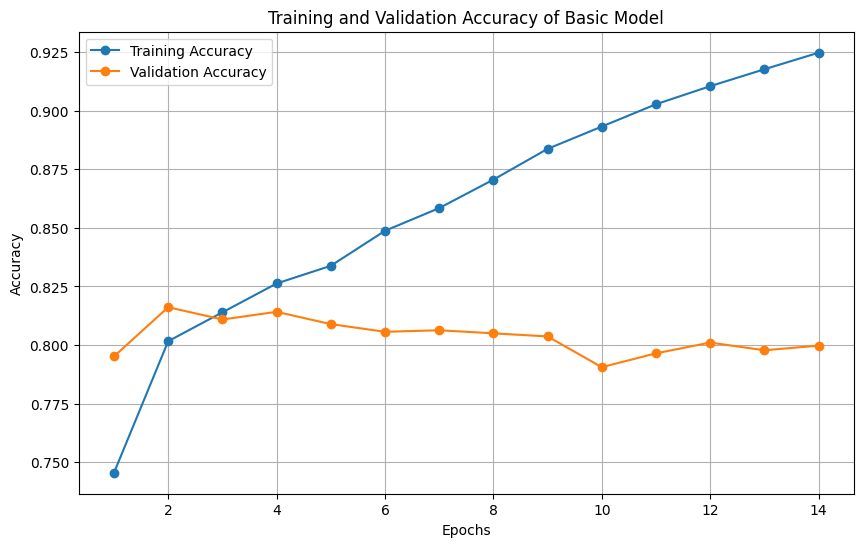

In [16]:
# Plot of Training Basic Model
# Extract accuracy values
train_accuracy = base_model_hist.history['accuracy']
val_accuracy = base_model_hist.history['val_accuracy']

# Extract epochs
epochs = range(1, len(train_accuracy) + 1)

# Plot training and validation accuracies
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy of Basic Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()



This is indicative of the model having too much capacity for the amount of data we have to train it on. One thing that can be done is limiting the unit size of the LSTM. I want to explore a couple of architectures however, since I have little experince with LSTM blocks, so I will run a hyperband tuning on some hyperparameters.



# Model + Hyperparameter Tuning

To select the optimal model and hyperparameters, I will use KerasTuner with Hyperband tuning. Below is an outline of the key hyperparameters and configurations:

- **LSTM Architecture**: I will explore architectures with 1 to 4 LSTM blocks. The number of blocks will be treated as a tunable hyperparameter.
- **Dropout Rate**: The dropout rate will be tuned with values `[0.1, 0.2, 0.3, 0.4, 0.5]` to prevent overfitting.
- **LSTM Unit Size**: The starting LSTM unit size will be tuned among `[32, 64, 128, 256]`. Each subsequent LSTM block (if present) will have half the units of the previous block.
- **Learning Rate**: The learning rate will be varied between **1e-2** and  **1e-5** to find the optimal value for model convergence.
- **L2 Regularization**: This is to combat the overfitting seen in the original problem, applied to the LSTM block both initially and recurently. Values selected are `[1e-2, 1e-3, 1e-4]`

By systematically tuning these parameters, I aim to identify a high-performing configuration for my text classification task.




In [37]:
def build_model(hp):
    model = Sequential()
    
    # Embedding layer (example input, modify as needed)
    model.add(Embedding(
        input_dim=len(word_index) + 1,  # Replace with your actual vocabulary size
        output_dim=embedding_dim,
        input_length=max_length,
        weights=[embedding_matrix],  # Pre-trained embedding matrix
        trainable=False
    ))
    
    global_unit_size = hp.Choice('units', values=[32, 64, 128, 256])
    global_dropout_rate = hp.Choice('dropout', values=[.1, .2, .3, .4, .5])
    global_depth = hp.Int('depth', min_value=1, max_value=4, step=1)
    global_regularization = hp.Choice('regularization', values=[1e-4, 1e-3, 1e-2])

    # Add LSTM layers based on depth
    for i in range(global_depth):  # Tuning depth
        model.add(LSTM(global_unit_size // (2**i), return_sequences=(i < global_depth - 1), kernel_regularizer=l2(global_regularization),recurrent_regularizer=l2(global_regularization)))
        model.add(Dropout(global_dropout_rate))  # Regularization
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model with a tunable learning rate
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', 1e-5, 1e-2, sampling='log')),  # Tune learning rate
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [39]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory='hyperband_tuning',
    project_name='text_classification'
)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [40]:
tuner.search(
    X_train_padded,
    np.array(labels),
    epochs=50,
    batch_size=4,
    validation_data = (X_val_padded, np.array(val_labels)),
    callbacks=[early_stopping]
)


Trial 90 Complete [00h 03m 00s]
val_accuracy: 0.8200919032096863

Best val_accuracy So Far: 0.8240315318107605
Total elapsed time: 03h 13m 06s


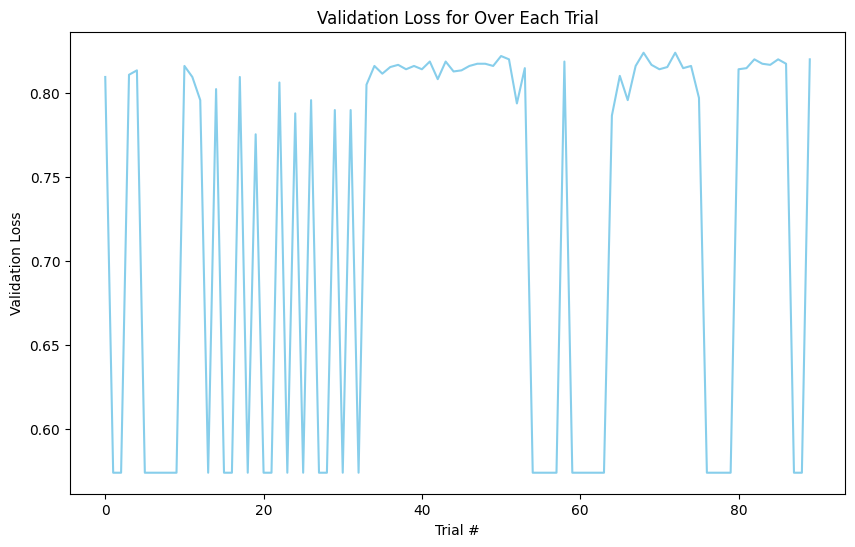

In [41]:
trials = tuner.oracle.trials.values()
val_losses = [trial.score for trial in trials]
plt.figure(figsize=(10, 6))
plt.plot(val_losses, color='skyblue')
plt.title('Validation Loss for Over Each Trial')
plt.xlabel('Trial #')
plt.ylabel('Validation Loss')
plt.show()

In [49]:
best_models = tuner.get_best_models(num_models=1)  # Retrieves the best model
best_model = best_models[0]


predictions = (best_model.predict(X_test_sequences) > .5) * 1

test_df['target'] = predictions

102/102 [==============================] - 1s 6ms/step


In [50]:
selected_columns = ['id', 'target']
df_selected = test_df[selected_columns]

# Save to CSV
df_selected.to_csv('predictions.csv', index=False)

## Tuning Results & Conclusion

Througout all the hyperparameter tuning, I was unable to get significantly better accuracy results that the intial attempt. Regularization and dropout did reduce the tendency for the model to overfit, however the validation accuracy also stagnated at about 82%. My only real guess as to why this is happening is the word embedding is not sufficient for this problem. In future attempts I would take a closer look at the embedder, specifically the type of embedder and the weights used. Turning the Embedding layer to trainable wouldn't work in this scenario since our input dataset is relatively small. 


The output F1 score that I acheived on Kaggle is **.79282**